# Planning

In [59]:
import gym 
%run "environment.py"
#goal is -1, empty block is 1, wall is 0, mortal block is 2
#rewards: normal:-0.1, goal:100, mortal block:-100
#maxtimesteps:100

structure=[
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ -1.,  1.,  1.,  1.,  1.,  1.,  1.]
]
#maze, step reward, final reward, timesteps, mortal block
env=maze(structure, -1, 100, 100, 0)
env.showEnv()

<img src="images/env.png">

## Dyna-Q

Once we created the model of the environment, we can train our agent. The agent is going to update its QTable using two sources: The **environment**, using the s,a experienced and using the **model** where the pair s,a is picked randomly among the s,a already experienced using the model to obtain their s',r.

In [60]:
import numpy as np

episodes=1000
discount=0.99
alpha=0.9
epsilon=0.1
k=0.5
n=30 #update 30 q(s,a) during planning

def policy(actions):
    #random action
    if np.random.random()<epsilon:
        return np.random.randint(0,3)
    else:
        bestActions=np.argwhere(actions == np.amax(actions))
        return np.random.choice(np.reshape(bestActions, -1))
    
#Sample trajectory planning
def planning(s,a,s1,r, QTable, model, trajectory):
    #create the model
    model[s][a]=[s1,r]
    #use planning
    for i in range(n):
        #pick randomly one s,a already visited
        if len(trajectory)>1:
            s,a=trajectory[np.random.randint(0, len(trajectory)-1)]
        else:
            s,a=trajectory[0]
        
        s1, r=model[s][a]
        QTable[s][a]=QTable[s][a] + alpha * (r + discount*QTable[s1][np.argmax(QTable[s1])] - QTable[s][a]) 
    return QTable, model
        
def dynaQ():
    #every s,a has a pair s',r. Create a table of state transictions
    model=np.zeros([env.getNStates(), env.getNActions(), 2], dtype="int")

    #QTable
    QTable=np.zeros([env.getNStates(), env.getNActions()])
    
    trajectory=[]
    
    rewList=[]
    stepsList=[]
    
    for episode in range (episodes):
        if episode==(episodes//2):
            env.changeEnv()        
        #reset the environment for a new game
        s=env.reset()

        d=False
        
        #count total reward for the single game and number of steps required to finish it
        reward=0
        steps=0
        while not(d):
            #select an action 
            a=policy(QTable[s])

            s1, r, d=env.step(a)
            s1=int(s1)
            r=int(r)

            QTable[s][a]=QTable[s][a] + alpha * (r + discount*QTable[s1][np.argmax(QTable[s1])]- QTable[s][a])
            trajectory.append([s,a])
            #create the model and execute planning
            QTable, model=planning(s,a,s1,r, QTable, model, trajectory)

            s=s1
            reward+=r
            steps+=1
            
        rewList.append(reward)
        stepsList.append(steps)
    return rewList,stepsList

## DynaQ+

DynaQ+ differens from the DynaQ algorithm because it uses a model that stores the number of timesteps since the last time that a *q(s,a)* has been selected. So, the model table will have dimension * \[N_states, N_actions, 3\]* . 
This information is used to give a extra value to the rewards of the *q(s,a)* that were not seen in a long time. In this way, the agent is encouraged to execute these *q(s,a)* in the real environment.

In [61]:
#Random planning
def planningDynaPlus(s,a,s1,r, timestep, QTable, model):
    #create the model
    model[s][a]=[s1,r, timestep]
    
    #use planning
    for i in range(n):
        #pick randomly a state
        s=np.random.randint(0,model.shape[0])
        
        #pick randomly one of the possible transitions from s 
        a=np.random.randint(0,env.getNActions())
        
        #retrieve the informations s1,r,last visit from the pair s,a
        s1, r, lastVisit=model[s][a]
        #compute how many timestep has been the last visit of this state
        t=timestep-lastVisit
        #add bonus to the reward
        r=r + k * np.sqrt(t)
        QTable[s][a]=QTable[s][a] + alpha * (r + discount*QTable[s1][np.argmax(QTable[s1])] - QTable[s][a]) 
    return QTable, model
    
def dynaQPlus():
    model=np.zeros([env.getNStates(), env.getNActions(), 3], dtype="int")
    QTable=np.zeros([env.getNStates(), env.getNActions()])
    
    rewList=[]
    stepsList=[]
    
    timestep=0
    for episode in range (episodes):
        if episode==(episodes//2):
            env.changeEnv()
            
        s=env.reset()

        d=False

        reward=0
        steps=0
        while not(d):
            
            a=policy(QTable[s])

            s1, r, d=env.step(a)
            s1=int(s1)
            r=int(r)

            QTable[s][a]=QTable[s][a] + alpha * (r + discount*QTable[s1][np.argmax(QTable[s1])] - QTable[s][a])   

            #create the model and execute planning
            QTable, model=planningDynaPlus(s,a,s1,r, timestep, QTable, model)

            s=s1
            reward+=r
            steps+=1
            
            #store training timestep (used to give extra reward)
            timestep+=1
            
        rewList.append(reward)
        stepsList.append(steps)
    return rewList,stepsList

## Q-Learning

In [62]:
def QL():
    QTable=np.zeros([env.getNStates(), env.getNActions()])
    
    stepsList=[]
    rewList=[]
    
    #Q-Learning algorithm
    for episode in range(episodes):
        if episode==(episodes//2):
            env.changeEnv()
        #reset the game for a new episode and return the state in which the agent is
        s = env.reset()

        #This variable became true if the game is finished
        d=False
        
        #count how many steps the agent needs to finish a single game
        steps=0
        reward=0
        while not(d):
            
            #given the state, select the action e-greedy
            action=policy(QTable[s])
            
            #return next state, reward, if the state has finished
            s1,r,d=env.step(action)
            #UPDATE ACTION-STATE FUNCTION
            QTable[s][action]=QTable[s][action] + alpha * ((r + discount*QTable[s1][np.argmax(QTable[s1])])-QTable[s][action])

            s=s1

            steps+=1
            reward += r

        rewList.append(reward)
        stepsList.append(steps)
    return rewList,stepsList

# Training and results

In [63]:
print("Training Dyna-Q..")
rewListDyna,stepsListDyna=dynaQ()

env=maze(structure, -1, 100, 100, 0)

print("\nTraining Dyna-QPlus..")
rewListDynaPlus,stepsListDynaPlus=dynaQPlus()

env=maze(structure, -1, 100, 100, 0)

print("\nTraining Q-Learning..")
rewListQL, stepsListQL=QL()

Training Dyna-Q..

Training Dyna-QPlus..

Training Q-Learning..


<function matplotlib.pyplot.show>

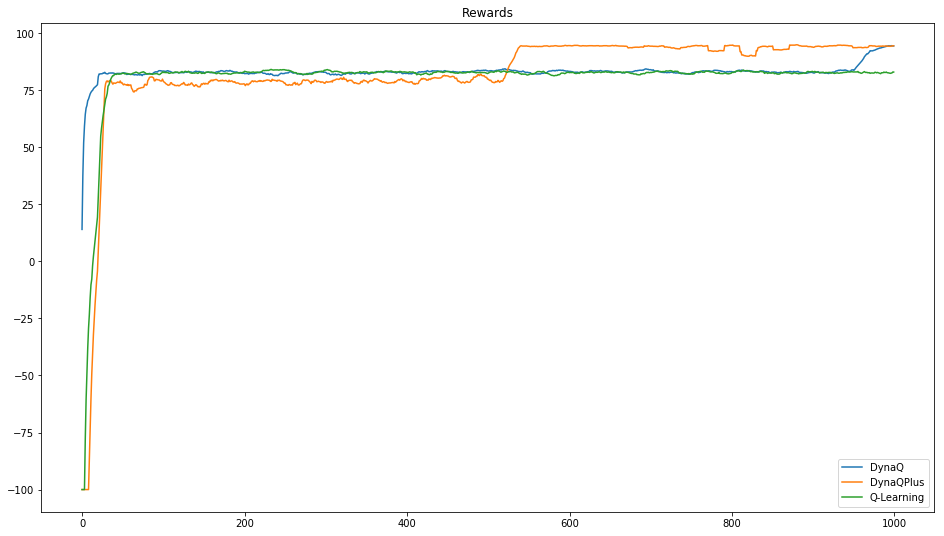

In [64]:
def movingAverage(data, size=20):
    averagedData=[]
    for idx, item in enumerate(data,1):
        if idx>=size:
            movAvg=np.sum(data[idx-size:idx])/size
        else:
            movAvg=np.sum(data[:idx])/idx
        averagedData.append(movAvg)
        
    return averagedData

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]
x=[i for i in range(episodes)]
rewListDyna=movingAverage(rewListDyna)
rewListDynaPlus=movingAverage(rewListDynaPlus)
rewListQL=movingAverage(rewListQL)

plt.plot(x, rewListDyna, label="DynaQ")
plt.plot(x, rewListDynaPlus, label="DynaQPlus")
plt.plot(x, rewListQL, label="Q-Learning")
plt.title("Rewards")
plt.legend(loc=0)
plt.show

<function matplotlib.pyplot.show>

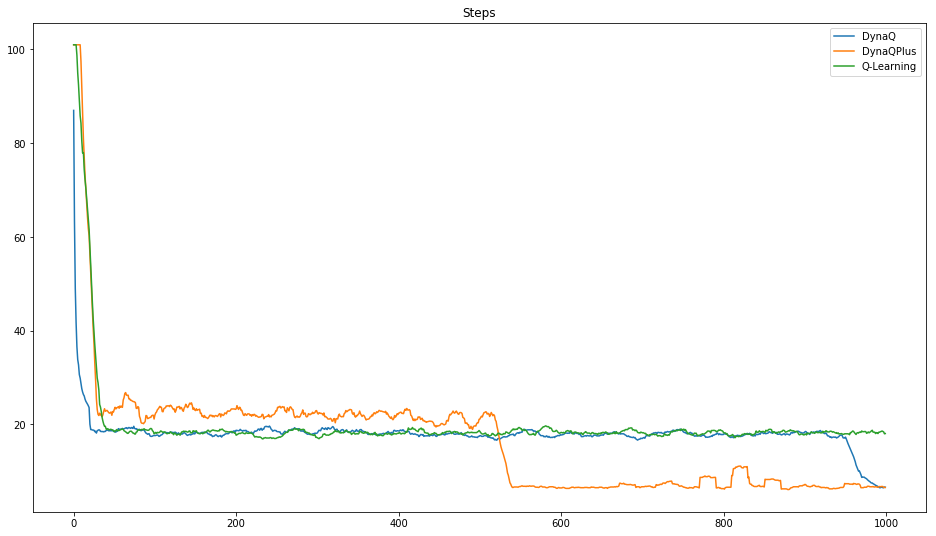

In [65]:
stepsListDyna=movingAverage(stepsListDyna)
stepsListDynaPlus=movingAverage(stepsListDynaPlus)
stepsListQL=movingAverage(stepsListQL)

plt.plot(x, stepsListDyna, label="DynaQ")
plt.plot(x, stepsListDynaPlus, label="DynaQPlus")
plt.plot(x, stepsListQL, label="Q-Learning")
plt.title("Steps")
plt.legend(loc=0)
plt.show

As you can notice, *DynaQ* and *DynaQ+* find the path quicker than *Q-Learning*. However, it is interesting to notice that *Dyna-Q+* perform slightly worst then the other models. The reason could be due to the fact that the value of *q(s,a)* is influenced by the number of timesteps since the last time the *s,a* has been selected. Although a *s,a* is not the optimal, it will have a higher value than the optimal one because has not been execute since long time ago.

After 500 episodes, the environment change, creating a shortcut. *DynaQ+* exploit the new optimal path in a banch of episodes. On the other hand, *Q-Learning* will never change their optimal path and *Dyna-Q* will do it after some time.